In [1]:
import torch 
from torch import nn, optim
from torch.utils.data import DataLoader

from models import SmallUNet, LargerUNet, LargestUNet
from datasets import DummyDataset, SegmentationDataset

from trainer import train

from utils import visualize_results, calculate_dice_score

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 16
num_epochs = 5
learning_rate = 0.001

# Privacy parameters
MAX_GRAD_NORM = 1.0
EPSILON = 1.0
DELTA = 1e-5

# Create dummy dataset and dataloader
# dataset = DummyDataset()
dataset = SegmentationDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
# model = SmallUNet(in_channels=1, out_channels=1).to(device)
model = LargerUNet(in_channels=1, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [3]:
# Train the model
train(model, dataloader, criterion, optimizer, device, num_epochs)
print("Normal Training completed!")

Epoch [1/5], Loss: 0.4915
Epoch [2/5], Loss: 0.3648
Epoch [3/5], Loss: 0.3169
Epoch [4/5], Loss: 0.2907
Epoch [5/5], Loss: 0.2658
Normal Training completed!


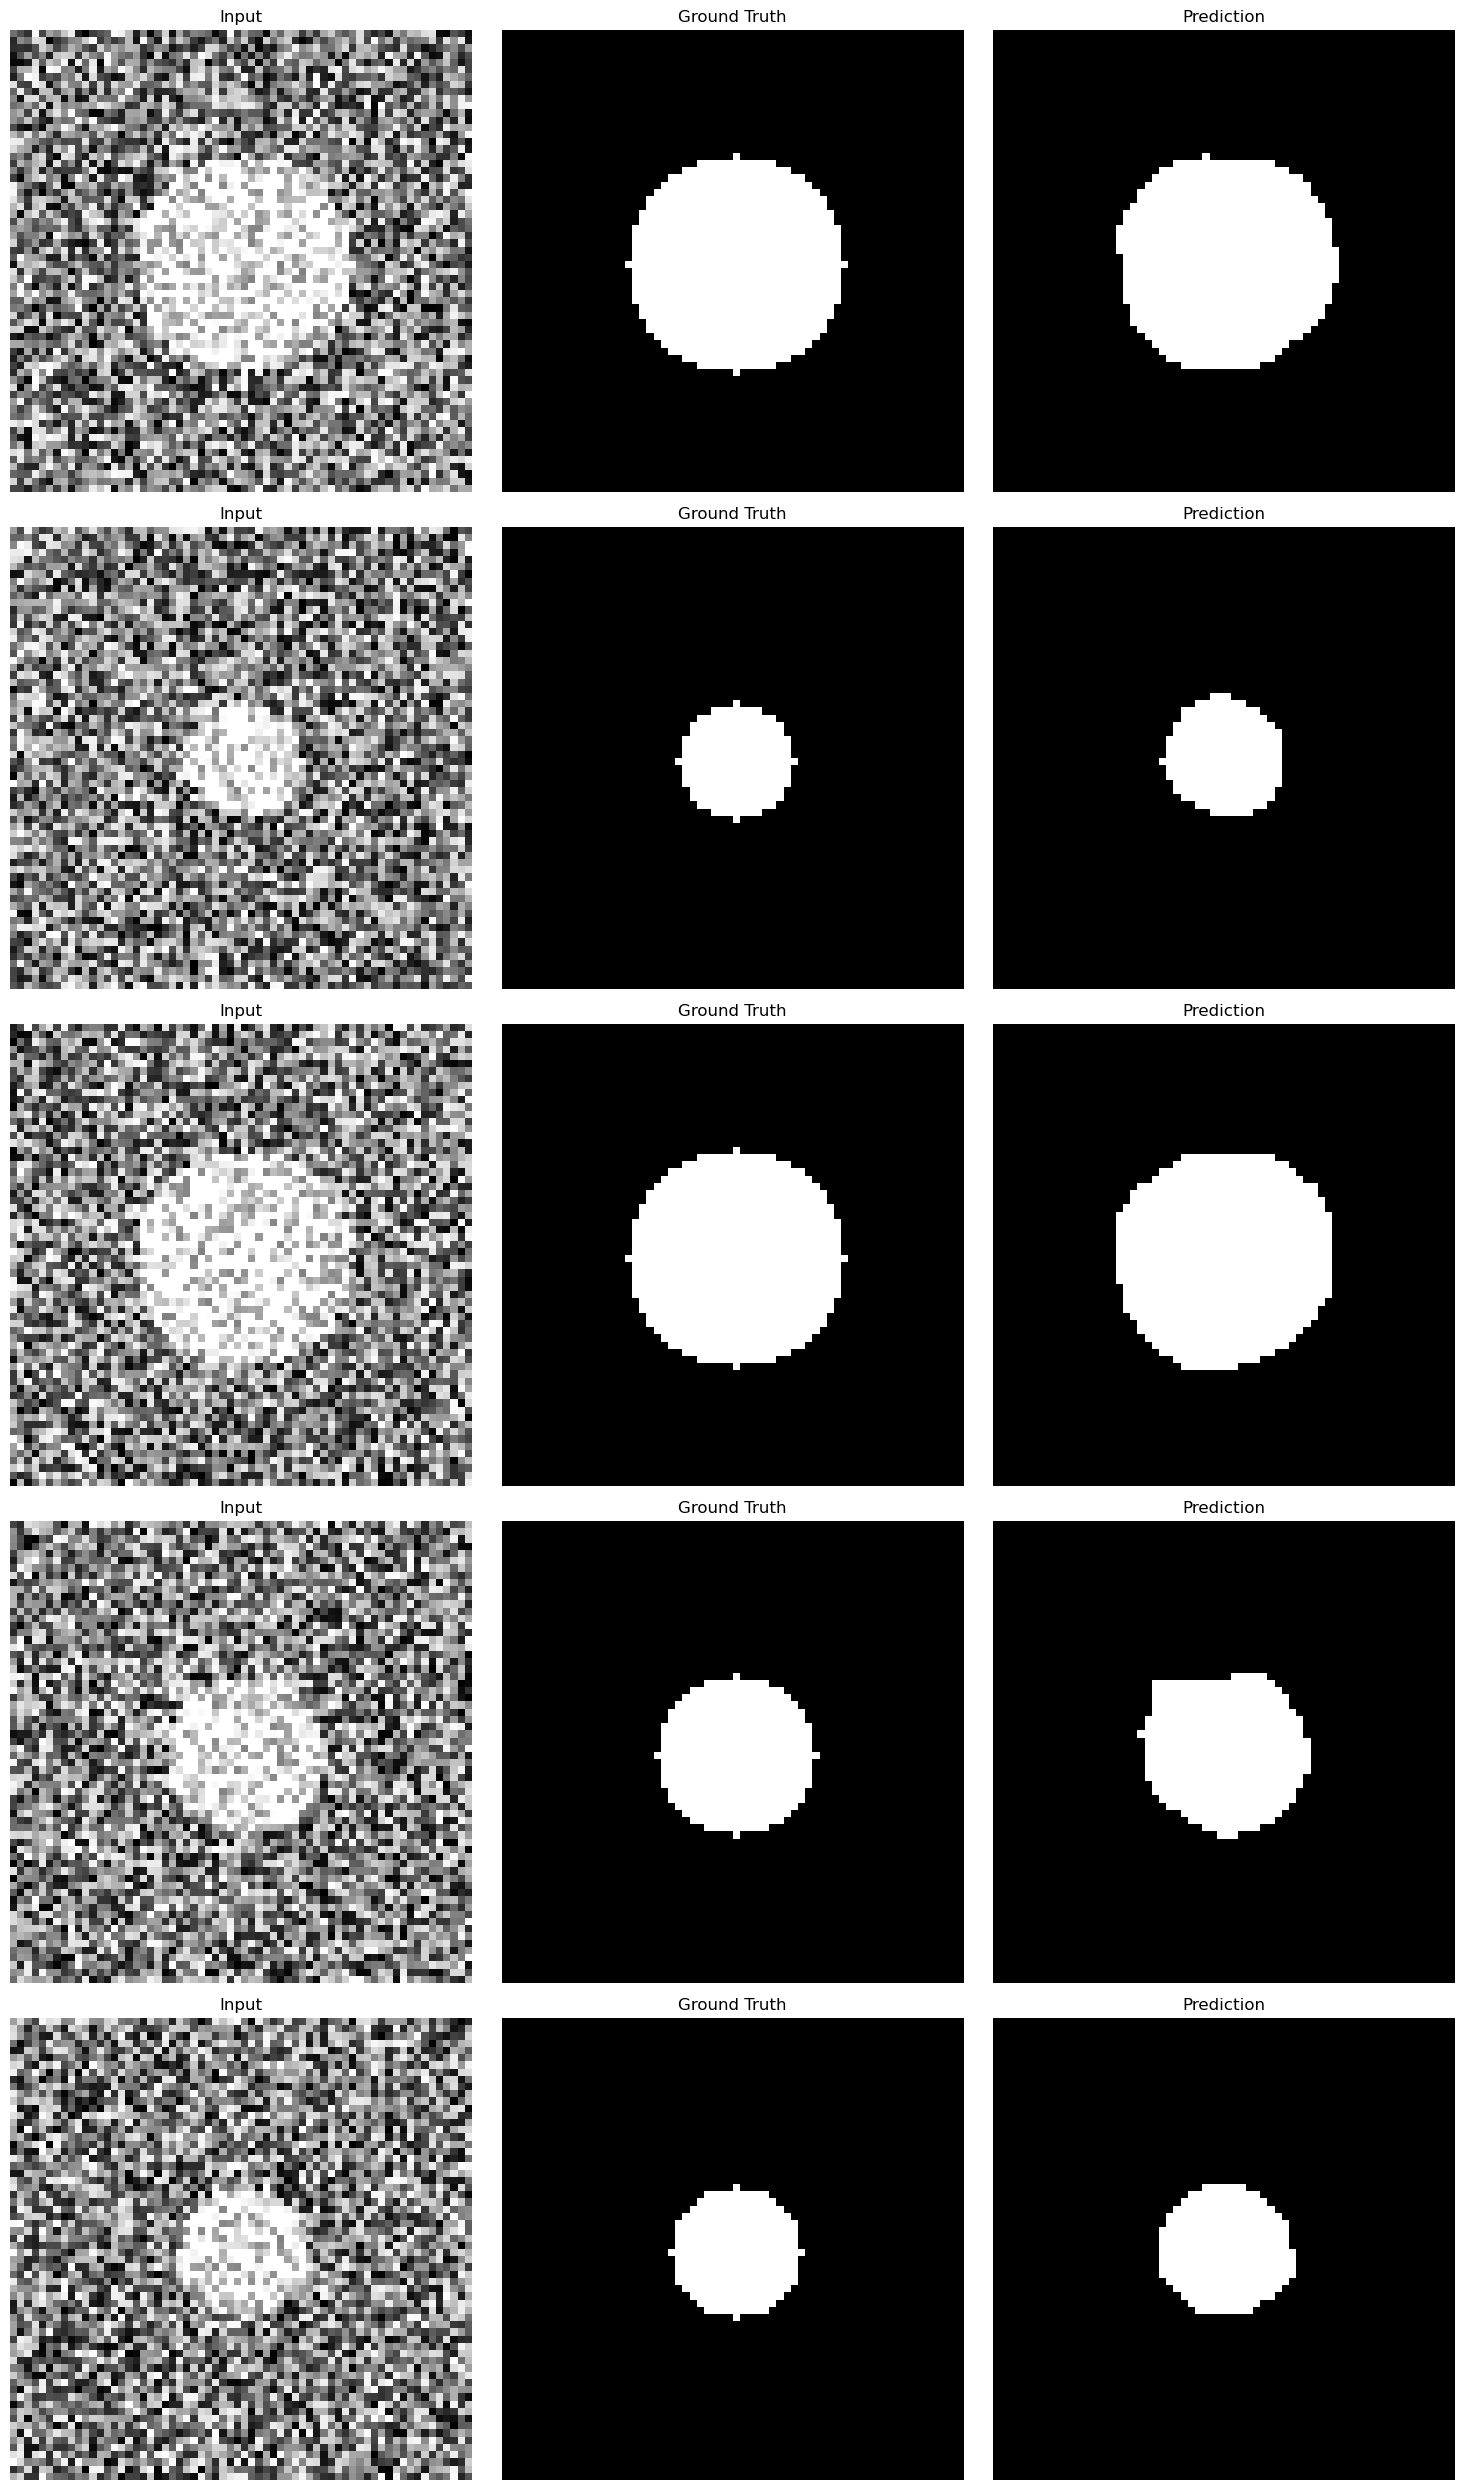

Dice score: 0.9593449091911316


In [4]:
# Visualize the model
visualize_results(model, dataset)

# Calculate the dice score
dice_score = calculate_dice_score(model, dataloader, device)
print(f"Dice score: {dice_score}")